In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
L = 500
x0 = 50
hbar=1
sigma = 20
dt = 0.01
frames = 100000
x = np.arange(L)
dx=1
horizon=L//2

k0_values = [0.0, 0.1, 0.2, 0.5, 0.9] #k0 values

results = {k0: {'time_list': [], 'x_c_list': []} for k0 in k0_values} #store results for each k0

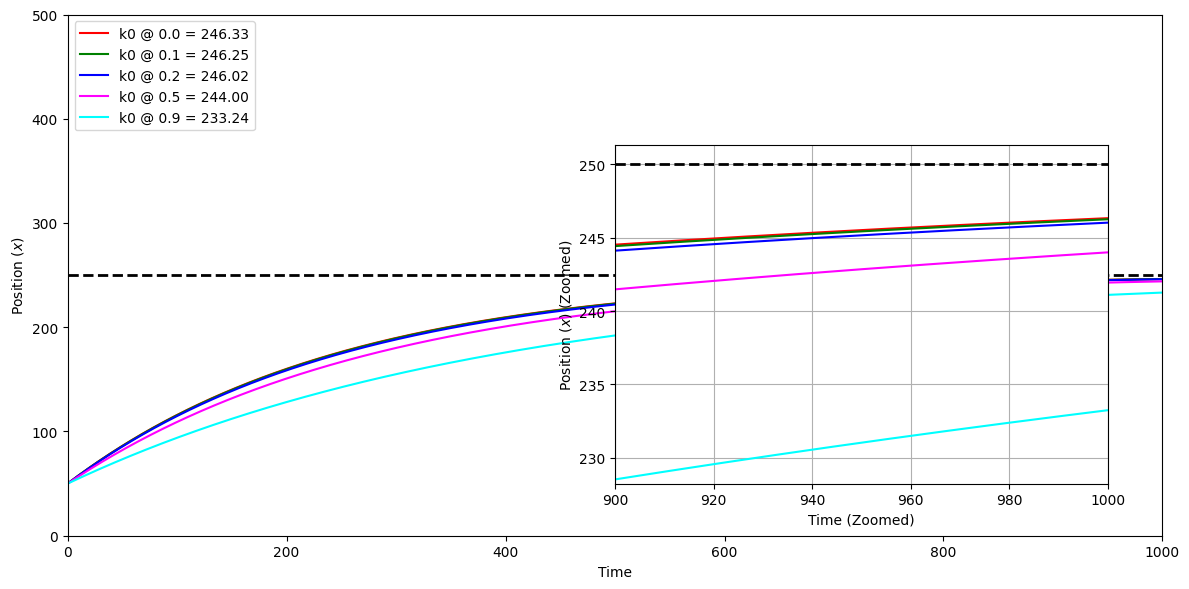

In [3]:
for k0 in k0_values:
    psi0 = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * k0 * (x-x0))
    psi0 /= np.sqrt(np.sum(np.abs(psi0)**2)) 

    psi = psi0.copy()
    time_list = []  
    x_c_list = []  
    t_list = []

    #time evolution loop
    for frame in range(frames):
        x_c = np.sum(x * np.abs(psi)**2) / np.sum(np.abs(psi)**2)
        t = 2 * x_c / L

        time_list.append(frame * dt)
        x_c_list.append(x_c)
        t_list.append(t)

        dpsi_dx=np.zeros(L, dtype=complex) #1st derivative entral difference
        dpsi_dx[1:-1] = (psi[2:] - psi[:-2]) / (2 * dx) 
        
        dpsi_dx[0] = (psi[1] - psi[-1]) / (2 * dx)  #feft boundary
        dpsi_dx[-1] = (psi[0] - psi[-2]) / (2 * dx)  #right boundary
        
        d3psi_dx3 = np.zeros_like(psi)  #array for 3rd derivative
        d3psi_dx3[2:-2] = (psi[4:] - 2 * psi[3:-1] + 2 * psi[1:-3] - psi[:-4]) / (2 * dx**3)
        
        # Third derivative (central difference with periodic boundary conditions)
        d3psi_dx3[0] = (psi[2] - 2 * psi[1] + 2 * psi[-1] - psi[-2]) / (2 * dx**3)  #left boundary
        d3psi_dx3[1] = (psi[3] - 2 * psi[2] + 2 * psi[0] - psi[-1]) / (2 * dx**3)  #2nd point
        d3psi_dx3[-1] = (psi[1] - 2 * psi[0] + 2 * psi[-2] - psi[-3]) / (2 * dx**3)  #right boundary
        d3psi_dx3[-2] = (psi[0] - 2 * psi[-1] + 2 * psi[-3] - psi[-4]) / (2 * dx**3)  #2nd to last point

        psi_next=(psi-(1j/hbar)*dt*((1-t)*(-1j*hbar*dpsi_dx))) #energy dispersion 1st model
        #psi_next=psi-(1j/hbar)*dt*((1-t)*(-1j*hbar*dpsi_dx) - (-1j*hbar**3 * d3psi_dx3) / 8) #energy dispersion 2nd model
        
        #periodic b.c
        psi_next[0] = psi_next[-1] #derivative is 0 at left boundary
        psi_next[-1] = psi_next[0] #derivative is 0 at right boundary
        
        psi_next /= np.sqrt(np.sum(np.abs(psi_next)**2 * dx)) #maintain total probability packet = 1
        psi=psi_next.copy() #update current psi after values calculated in psi_next 

    #save results for this k0
    results[k0]['time_list'] = time_list
    results[k0]['x_c_list'] = x_c_list
    results[k0]['t_list'] = t_list

colors = ['red', 'green', 'blue', 'magenta', 'cyan']
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list']
    x_c_list = results[k0]['x_c_list']
    final_x_c = x_c_list[-1]
    ax1.plot(time_list, x_c_list, label=f'k0 @ {k0} = {final_x_c:.2f}', color=colors[i])

#set labels and limits for the main axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Position $(x)$')
ax1.set_xlim(0, frames * dt)
ax1.set_ylim(0, L)  
ax1.axhline(horizon, color='black', linestyle='--', linewidth=2)
ax1.legend(loc='upper left')

#create a zoomed-in view for the final region
ax2 = ax1.inset_axes([0.5, 0.1, 0.45, 0.65])  # [x, y, width, height] in relative coordinates
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list']
    x_c_list = results[k0]['x_c_list']
    final_x_c = x_c_list[-1]
    ax2.plot(time_list, x_c_list, label=f'k0 @ {k0} = {final_x_c:.2f}', color=colors[i])

#set labels and limits for the zoomed-in 
ax2.set_xlim(0.9 * frames * dt, frames * dt) 
ax2.set_ylim(min([results[k0]['x_c_list'][-1] for k0 in k0_values]) - 5,
             max([results[k0]['x_c_list'][-1] for k0 in k0_values]) + 5) 
ax2.axhline(horizon, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Time (Zoomed)')
ax2.set_ylabel('Position $(x)$ (Zoomed)')
ax2.grid(True)

plt.tight_layout()
plt.savefig("FDM_2 zoomed superimposed.png", dpi=600, bbox_inches='tight')
plt.show()